## Description

**Author: Łukasz Łaszczuk**

This notebook focuses on training decision trees and tuning it for detecting fraudulent credit card transactions.

## Import modules and data

In [1]:
import copy
import warnings
import pydotplus
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

In [2]:
from sklearn.model_selection import (learning_curve, RandomizedSearchCV,
                                     StratifiedShuffleSplit, StratifiedKFold,
                                     train_test_split,
                                    )
from sklearn.metrics import (accuracy_score, average_precision_score,
                             classification_report, confusion_matrix,
                             f1_score, precision_recall_curve,
                             precision_score, recall_score, 
                             roc_auc_score, roc_curve,
                            )
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.utils.class_weight import (compute_class_weight,
                                        compute_sample_weight)
from sklearn.base import clone
from scikitplot.metrics import plot_precision_recall
from joblib import dump, load
from io import StringIO
from ipywidgets import Image

In [3]:
%config InlineBackend.figure_format='retina'
warnings.filterwarnings('ignore')

**Firstly, let's perform feature engineering**

In [4]:
def feature_engineering(df):
    """Perform feature engineering described in
    EDA_and_baseline_scores notebook.
    """
    
    # Amount equal 99.99, transaction concluded in group 
    df_new = df.sort_values(["Time", "V1"])
    df_new = df_new[(df_new["Amount"] == 99.99)]
    df_new["diff"] = df_new["Time"].diff()
    diff = df_new["diff"]
    df = df.join(diff)
    df["Amount_99_group"] = (df["diff"] < 40).astype(int)
    df.drop("diff", axis=1, inplace=True)
    
    # Log transform of Amount
    df["Amount"] = np.log1p(df["Amount"])
    
    # Sine and cosine transformation of time
    seconds_in_day = 86400
    df["Time"] = df["Time"] % seconds_in_day
    df["Sin_time"] = np.sin(2*np.pi*df["Time"] / seconds_in_day)
    df["Cos_time"] = np.cos(2*np.pi*df["Time"] / seconds_in_day)
    df.drop("Time", axis=1, inplace=True)
    
    return df

In [8]:
df = pd.read_csv("data\data1.csv")
df.drop(df.columns[0], inplace=True, axis=1)  # Drop first column (index)
df = feature_engineering(df)

In [9]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V24,V25,V26,V27,V28,Amount,Class,Amount_99_group,Sin_time,Cos_time
0,2.004188,-0.287498,-1.984934,0.342239,0.413188,-0.815346,0.445456,-0.299258,0.562445,0.109932,...,0.504076,0.176423,0.541252,-0.121212,-0.064948,4.189503,0,0,0.143924,-0.989589
1,2.346905,-1.264915,-1.034900,-1.568721,-1.122435,-0.790624,-1.011732,-0.268243,-1.229191,1.576645,...,-0.432445,-0.119139,-0.131627,0.015176,-0.058104,0.693147,0,0,-0.653255,-0.757138
2,-3.089671,2.464689,0.042745,1.670674,-2.129076,0.600262,-1.627285,2.452801,0.319063,-0.526330,...,0.091483,-0.038373,-0.410096,0.088944,0.026973,3.456317,0,0,-0.964365,0.264574
3,1.792358,-0.384458,-2.170063,0.096243,0.291162,-1.510182,0.921037,-0.525263,-0.088484,0.119203,...,0.146116,0.342753,0.198887,-0.117734,-0.061706,5.044006,0,0,0.417537,-0.908660
4,2.188008,-0.400212,-1.627908,-0.225692,-0.133549,-1.273351,0.226144,-0.553975,-0.908684,0.877520,...,0.049313,0.157236,0.606729,-0.063450,-0.071105,2.397895,0,0,0.572265,-0.820069


**We will use stratified train test split to ensure the proportion of frauds in train and test set is the same.**

In [10]:
X = df.loc[:, df.columns != "Class"]  # select features for predicting Class
X = X.astype("float32")  # convert the chosen features to float32 type
y = df["Class"]  # target column
y = y.astype("int32")
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    stratify=y,
                                                    random_state = 2019)
# Stratified cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2019)

## Optimizing hyperparameters of decision tree with RandomizedSearchCV

**To compensate class imbalance, we use sample_weight argument in fit function. We define positive class weight as: $$ positives\_weight = \frac{\# transactions}{\# frauds}$$** <br>
We will use compute_sample_weight function from scikit-learn package for computing the weights.

In [45]:
compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)

array([  0.50086423, 289.77325581])

In [8]:
df_frauds = df[df["Class"] == 1]
scale_pos_weight = df.shape[0] / df_frauds.shape[0]
tree = DecisionTreeClassifier(random_state=2019,
                              class_weight={0: 1, 1: scale_pos_weight},
                             )
params = {"max_depth": np.arange(2,11),
          "min_samples_leaf": np.arange(2,11),
          "min_samples_split": np.arange(2,11),
         }

In [11]:
# For scoring and evaluating, we use average_precision
grid = RandomizedSearchCV(tree, params,
                          n_iter=100, scoring="average_precision",
                          cv=skf, verbose=1,
                          n_jobs=-1, random_state=2019,)

In [5]:
grid.fit(X_train, y_train)

NameError: name 'grid' is not defined

In [53]:
# Let's take a look at best models
results = pd.DataFrame(grid.cv_results_).sort_values("rank_test_score")
results = results.reset_index(drop=True)
results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,7.937437,0.977462,0.013501,0.000913,10,10,9,"{'min_samples_split': 10, 'min_samples_leaf': ...",0.690577,0.650768,0.623591,0.656077,0.791526,0.682507,0.058527,1
1,6.817856,0.580724,0.013963,0.000892,9,10,9,"{'min_samples_split': 9, 'min_samples_leaf': 1...",0.690577,0.650768,0.623591,0.656077,0.791526,0.682507,0.058527,1
2,6.246210,0.676283,0.017375,0.008582,10,7,10,"{'min_samples_split': 10, 'min_samples_leaf': ...",0.677706,0.678553,0.448152,0.610495,0.770276,0.637036,0.107250,3
3,7.686839,0.516483,0.013988,0.001655,7,8,10,"{'min_samples_split': 7, 'min_samples_leaf': 8...",0.679966,0.656427,0.463331,0.626454,0.752571,0.635749,0.095754,4
4,6.975921,0.558260,0.013579,0.001954,6,8,10,"{'min_samples_split': 6, 'min_samples_leaf': 8...",0.679966,0.656427,0.463331,0.626454,0.752571,0.635749,0.095754,4
5,6.779959,0.536827,0.013177,0.001481,9,9,9,"{'min_samples_split': 9, 'min_samples_leaf': 9...",0.657280,0.626674,0.453660,0.628360,0.790015,0.631197,0.107193,6
6,7.736430,0.544230,0.015397,0.003958,4,8,9,"{'min_samples_split': 4, 'min_samples_leaf': 8...",0.668794,0.626781,0.454278,0.582877,0.767392,0.620024,0.102950,7
7,7.559357,0.761388,0.013765,0.000747,8,8,9,"{'min_samples_split': 8, 'min_samples_leaf': 8...",0.668794,0.626781,0.454278,0.582877,0.767392,0.620024,0.102950,7
8,5.459520,0.472996,0.009875,0.000195,10,10,8,"{'min_samples_split': 10, 'min_samples_leaf': ...",0.660745,0.547697,0.451003,0.628190,0.791494,0.615825,0.113875,9
9,6.730314,0.612926,0.012379,0.001013,3,10,8,"{'min_samples_split': 3, 'min_samples_leaf': 1...",0.660745,0.547697,0.451003,0.628190,0.791494,0.615825,0.113875,9


In [54]:
# cross validation average_precision of the best model
grid.best_score_

0.68250740027101

In [55]:
grid.best_params_

{'min_samples_split': 10, 'min_samples_leaf': 10, 'max_depth': 9}

In [56]:
model = grid.best_estimator_

In [33]:
# average_precision of best estimator from param grid on test set
y_pred = model.predict(X_test)
average_precision_score(y_test,y_pred)

0.15203866764957835

**This score is 0.12 larger than the baseline score with decision tree**

In [34]:
f1_score(y_test,y_pred)

0.30405405405405406

In [35]:
confusion_matrix(y_test,y_pred)

array([[63580,   391],
       [   21,    90]], dtype=int64)

In [36]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [37]:
tn, fp, fn, tp

(63580, 391, 21, 90)

**We see more False Negatives than False Positives, which is not a positive phenomenon. Not detecting a fraud (FN) carries a significantly larger cost than the inverse case (FP). We can recoup this, by setting lower treshold, thus reducing the number of FN in cost of increasing FP.**

In [38]:
y_proba = model.predict_proba(X_test)

In [39]:
# Set threshold
y_test_threshold = (y_proba[:, 1] >= 0.999).astype(int)
print(classification_report(y_test, y_test_threshold))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     63971
           1       0.95      0.77      0.85       111

    accuracy                           1.00     64082
   macro avg       0.97      0.89      0.93     64082
weighted avg       1.00      1.00      1.00     64082



In [40]:
# Check for FN and FP
confusion_matrix(y_test, y_test_threshold)

array([[63966,     5],
       [   25,    86]], dtype=int64)

In [41]:
average_precision_score(y_test, y_test_threshold)

0.7325948573568809

In [31]:
f1_score(y_test, y_test_threshold)

0.8426395939086295

**By setting threshold to 0.2 we reduced the number of FN by 5. The cost was an increse in FP by 6.**

**Let's plot precision - recall curve**

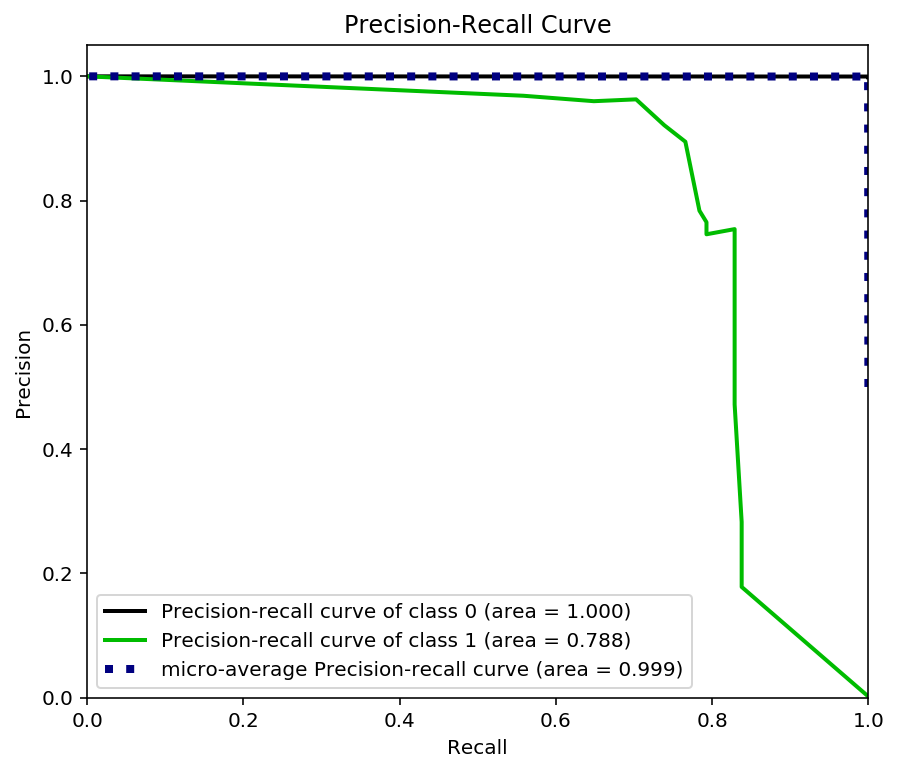

In [113]:
plot_precision_recall(y_test, y_proba, figsize=(7,6));

**Note: There is a difference between average_precision_score and area calculated by plot_precision_recall. In sklearn documentation, we can read that AUPRC calculated by the second function uses linear interpolation and can be a little bit too optimistic, so we stick to average_precision_score.**

In [20]:
# best grid tree visualization
dot_data = StringIO()
export_graphviz(decision_tree=model,
               out_file=dot_data, filled=True,
               feature_names=df.drop(['Class'],axis=1).columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(value=graph.create_png())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x15\x9b\x00\x00\x04\xa7\x08\x06\x00\x00\x00-7b\xc0\x…

In [21]:
def plot_importances(est, columns):
    
    importances = est.feature_importances_
    
    fig, ax = plt.subplots(figsize=(10,8))
    ax.barh(columns, importances)
    ax.set_title("Decision tree feature importances")
    
    return fig

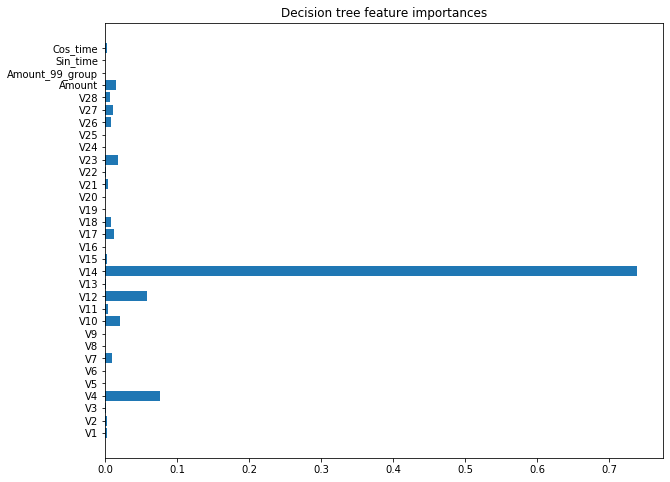

In [22]:
columns = df.drop(["Class"], axis=1).columns
fig = plot_importances(model, columns)

**Note: By plotting feature importances we can see that most of the features were not considered. Sin_time feature, which was created before is the 4th most important feature.**

**Let's check if any other model (20 best models) from the grid will score better than the best model.**

In [170]:
def check_models(grid, results, n, X_train, y_train, X_test, y_test, threshold):
    """Fit and Test n best models from grid. Return the best estimator,
    AUPRC of each model and best parameters.
    """
    scores = dict()
    best_score = 0
    for i in range(n):
        param = results.loc[i, "params"]
        clf = grid.best_estimator_.set_params(**param)
        clf.fit(X_train, y_train)
        y_pred_proba = clf.predict_proba(X_test)
        y_pred = (y_pred_proba[:, 1] >= threshold).astype(int)
        scores[i] = average_precision_score(y_test, y_pred)
        if scores[i] > best_score:
            best_score = scores[i]
            best_est = copy.deepcopy(clf)
            best_params = param
            
    return best_est, scores, best_params

In [171]:
# We will check 20 best models
best_est, scores, best_params = check_models(grid, results, 20,
                                             X_train, y_train,
                                             X_test, y_test, 0.999)

In [172]:
scores  # We can check which model had the best AUPRC

{0: 0.6810882370481396,
 1: 0.6810882370481396,
 2: 0.7036259217454651,
 3: 0.7216022663262137,
 4: 0.7216022663262137,
 5: 0.7221004641595121,
 6: 0.7131181519597465,
 7: 0.7131181519597465,
 8: 0.6958576573367916,
 9: 0.6958576573367916,
 10: 0.7221004641595121,
 11: 0.7131181519597465,
 12: 0.7131181519597465,
 13: 0.7246361102676991,
 14: 0.7246361102676991,
 15: 0.7227800575230432,
 16: 0.7221004641595121,
 17: 0.7221004641595121,
 18: 0.7325948573568809,
 19: 0.7325948573568809}

In [173]:
best_est

DecisionTreeClassifier(class_weight={0: 1, 1: 578.8753387533875},
                       criterion='gini', max_depth=8, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=8,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       presort=False, random_state=2019, splitter='best')

In [174]:
best_params

{'min_samples_split': 10, 'min_samples_leaf': 8, 'max_depth': 8}

In [176]:
y_pred = (best_est.predict_proba(X_test)[:,1]>=0.999).astype(int)
average_precision_score(y_test, y_pred)

0.7325948573568809

In [177]:
f1_score(y_test, y_pred)

0.8514851485148515

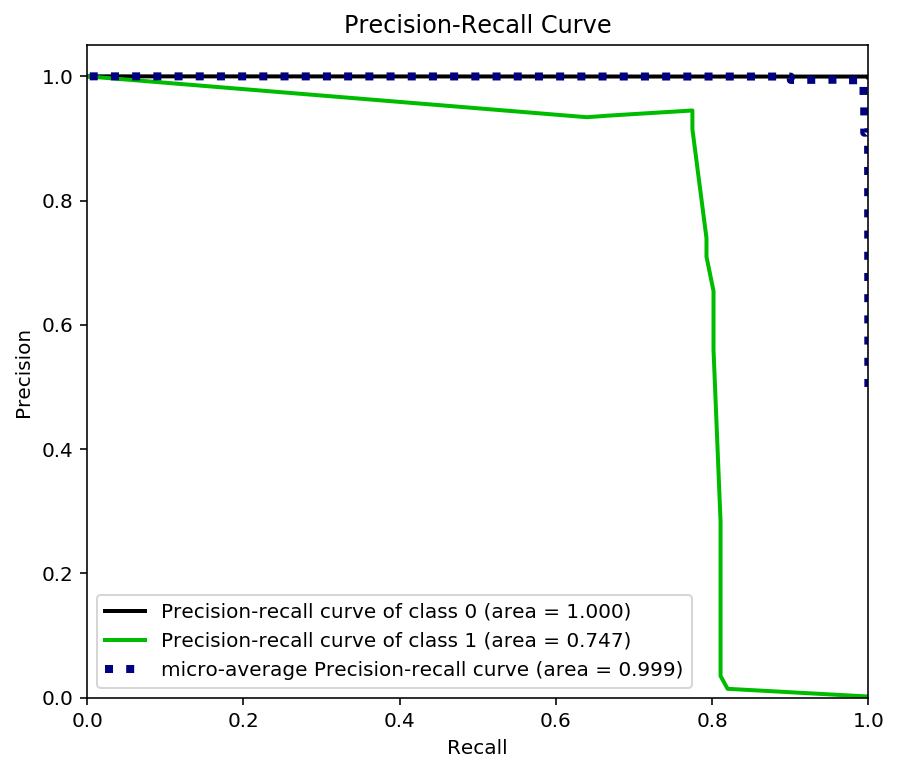

In [179]:
y_proba = best_est.predict_proba(X_test)
plot_precision_recall(y_test, y_proba, figsize=(7,6));

In [178]:
dump(best_est, "drzewko_best.joblib")

['drzewko_best.joblib']

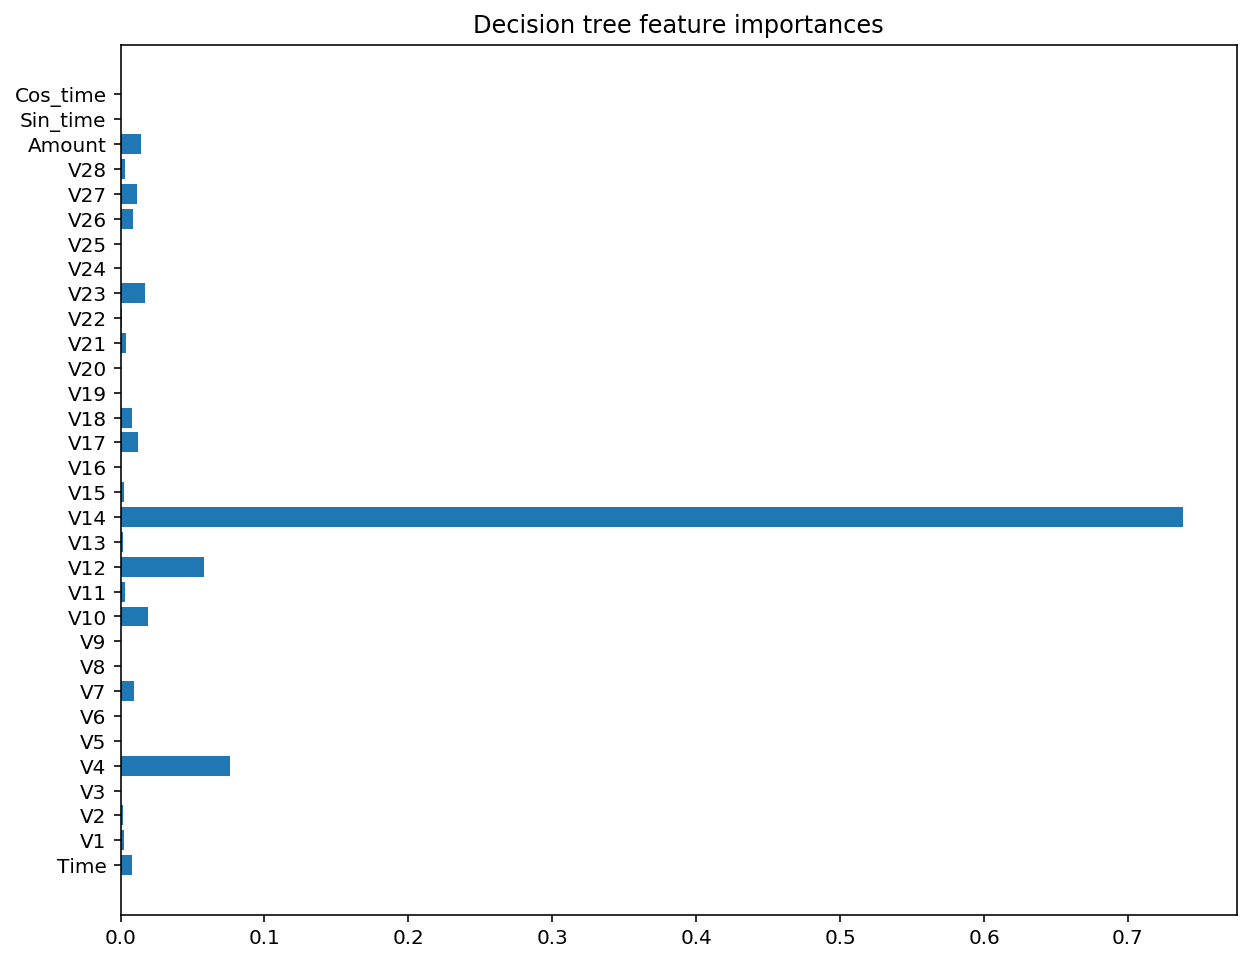

In [181]:
fig = plot_importances(best_est, columns)

**We can see that model with index 12 had the best test AUPRC. The score is 0.015 larger than the best model on CV.**

In [138]:
y_proba = best_est.predict_proba(X_test)

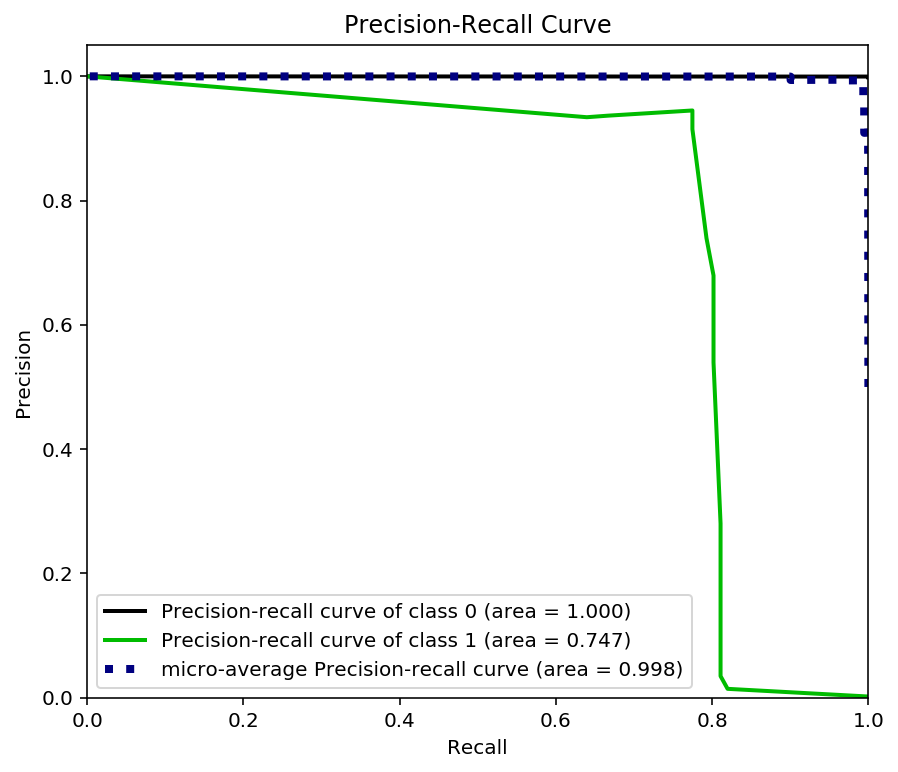

In [139]:
plot_precision_recall(y_test, y_proba, figsize=(7,6));

In [140]:
confusion_matrix(y_test, y_pred)

array([[63578,   393],
       [   21,    90]], dtype=int64)

In [141]:
y_proba = best_est.predict_proba(X_test)

In [142]:
# Set threshold
y_test_threshold = (y_proba[:, 1] >= 0.999).astype(int)
print(classification_report(y_test, y_test_threshold))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     63971
           1       0.95      0.77      0.85       111

    accuracy                           1.00     64082
   macro avg       0.97      0.89      0.93     64082
weighted avg       1.00      1.00      1.00     64082



In [143]:
print(confusion_matrix(y_test, y_test_threshold))

[[63966     5]
 [   25    86]]


In [144]:
average_precision_score(y_test, y_test_threshold)

0.7325948573568809

**This model makes 2 less mistakes than the previous one. The difference isn't significant and with different test set, it might perform worse than the previous model.**

In [444]:
dot_data = StringIO()
export_graphviz(decision_tree=best_est,
               out_file=dot_data, filled=True,
               feature_names=df.drop(['Class'],axis=1).columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(value=graph.create_png())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x0b\x08\x00\x00\x04\x1c\x08\x06\x00\x00\x00\x8b&]Q\x…

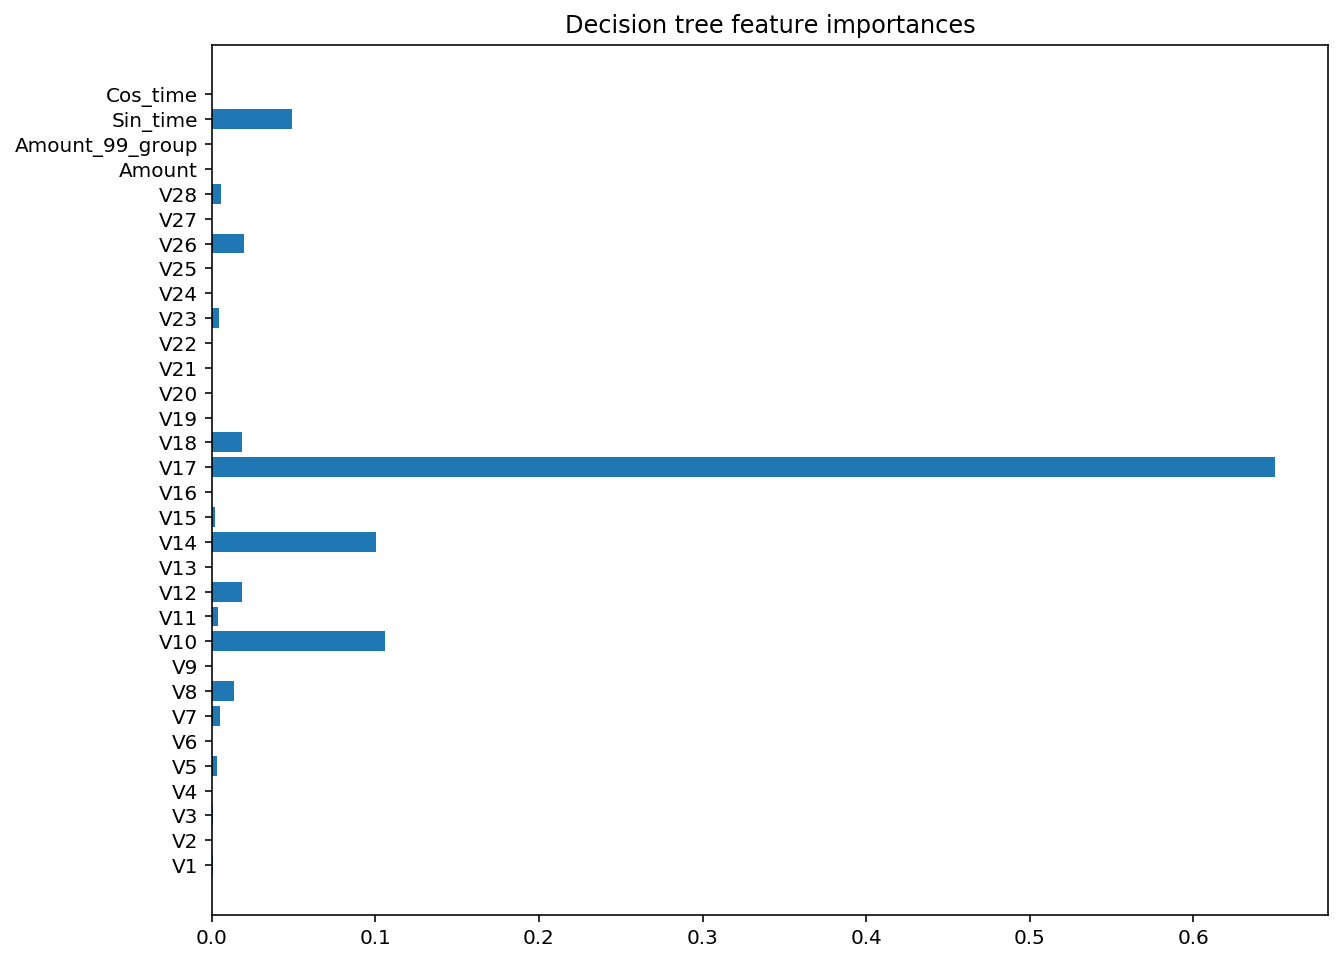

In [445]:
fig = plot_importances(best_est, columns)

**Feature importance graph is similar to the previous one**